# Centrality Measures in Social Networks 📱

Welcome to this comprehensive tutorial on applying centrality measures to real social network data! In this notebook, we'll explore how graph theory can be used to analyze social networks and identify influential users.

## Concepts Covered:
- **Loading Real Social Network Data**: https://github.com/eleurent/twitter-graph
- **Centrality Measures**: Degree, Betweenness, Eigenvector, PageRank, Closeness Centrality
- **Influential User Identification**: Finding key users in social networks
- **Community Structure**: Understanding network topology
- **Real-World Applications**: Marketing, information spread, viral content analysis

## What You'll Learn:
1. How to load and analyze real social network datasets
2. How to compute various centrality measures on large networks
3. How to identify influential users and opinion leaders
4. How different centrality measures reveal different types of influence
5. Visualizing and interpreting centrality results in social networks

In [1]:
import os
import random
import time
import warnings
import zipfile
from collections import defaultdict

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import requests

warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## Part I: Loading Real Social Network Data

We'll load a real social network from the **friends.gephi** file. This is a real social network graph exported from Twitter, containing friendship connections with many nodes and edges.

See: https://github.com/eleurent/twitter-graph

In [2]:
G = nx.read_graphml('data/friends.graphml')
G = G.to_undirected()

# only for testing:
#n_sub = min(1000, G.number_of_nodes())
#sample_nodes = random.sample(list(G.nodes()), n_sub)
#G = G.subgraph(sample_nodes).copy()

# Create a mapping from node ID to display name
# Check for common attribute names that might contain profile names
def get_display_name(node_id, node_attrs):
    """Extract display name from node attributes, fallback to node_id."""
    # Common attribute names for profile names
    name_attrs = ['label', 'Label', 'name', 'Name', 'screen_name', 'screenName', 
                  'username', 'userName', 'display_name', 'displayName', 'id_str']
    
    for attr in name_attrs:
        if attr in node_attrs and node_attrs[attr]:
            name = str(node_attrs[attr]).strip()
            if name and name != node_id:  # Only use if it's different from ID
                return name
    
    # Fallback to node_id
    return str(node_id)

# Build name mapping
node_to_name = {}
for node_id in G.nodes():
    node_attrs = G.nodes[node_id]
    node_to_name[node_id] = get_display_name(node_id, node_attrs)

# Check what attributes are available
if G.nodes():
    sample_node = list(G.nodes())[0]
    sample_attrs = G.nodes[sample_node]
    print(f"\n📋 Sample node attributes: {list(sample_attrs.keys())}")
    print(f"   Sample node ID: {sample_node}")
    print(f"   Sample display name: {node_to_name[sample_node]}")

print(f"\n✅ Social network loaded!")
print(f"   Nodes: {G.number_of_nodes():,}")
print(f"   Edges: {G.number_of_edges():,}")

print(f"   Average degree: {2 * G.number_of_edges() / G.number_of_nodes():.2f}")
print(f"   Density: {nx.density(G):.6f}")
print(f"   Connected: {nx.is_connected(G)}")

if not nx.is_connected(G):
    components = list(nx.connected_components(G))
    print(f"   Components: {len(components)}")
    largest_cc = max(components, key=len)
    G = G.subgraph(largest_cc).copy()
    # Update name mapping for subgraph
    node_to_name = {node: node_to_name.get(node, str(node)) for node in G.nodes()}
    print(f"   Using largest component: {G.number_of_nodes():,} nodes, {G.number_of_edges():,} edges")


📋 Sample node attributes: ['label', 'name', 'screen_name', 'location', 'description', 'entities', 'protected', 'followers_count', 'friends_count', 'listed_count', 'created_at', 'favourites_count', 'geo_enabled', 'verified', 'statuses_count', 'status', 'contributors_enabled', 'is_translator', 'is_translation_enabled', 'profile_background_color', 'profile_background_image_url', 'profile_background_image_url_https', 'profile_background_tile', 'profile_image_url', 'profile_image_url_https', 'profile_banner_url', 'profile_link_color', 'profile_sidebar_border_color', 'profile_sidebar_fill_color', 'profile_text_color', 'profile_use_background_image', 'has_extended_profile', 'default_profile', 'default_profile_image', 'following', 'live_following', 'follow_request_sent', 'notifications', 'muting', 'blocking', 'blocked_by', 'translator_type', 'PageRank', 'Modularity Class', 'Component ID', 'giantcomponent', 'size', 'r', 'g', 'b', 'x', 'y']
   Sample node ID: 1608763560
   Sample display name: 

### 1.1 Network Statistics and Basic Analysis

Let's explore the basic properties of our social network to understand its structure.


In [3]:
# Compute basic network statistics
print("📊 NETWORK STATISTICS")
print("=" * 60)

# Degree distribution
degrees = [G.degree(n) for n in G.nodes()]
degree_series = pd.Series(degrees)

print(f"\n📈 Degree Distribution:")
print(f"   Mean degree: {degree_series.mean():.2f}")
print(f"   Median degree: {degree_series.median():.2f}")
print(f"   Max degree: {degree_series.max()}")
print(f"   Min degree: {degree_series.min()}")
print(f"   Std deviation: {degree_series.std():.2f}")

# Network metrics
print(f"\n🌐 Network Topology:")
print(f"   Average clustering coefficient: {nx.average_clustering(G):.4f}")
print(f"   Transitivity: {nx.transitivity(G):.4f}")
#print(f"   Diameter: {nx.diameter(G)}")
print(f"   Average path length: {nx.average_shortest_path_length(G):.4f}")

# Power-law check (real social networks often follow power-law)
print(f"\n📉 Network Properties:")
print(f"   Is scale-free (power-law): Checking degree distribution...")
# Check if degree distribution follows power-law (many low-degree, few high-degree)
high_degree_nodes = sum(1 for d in degrees if d > degree_series.quantile(0.9))
print(f"   High-degree nodes (>90th percentile): {high_degree_nodes} ({100*high_degree_nodes/len(degrees):.2f}%)")

# Visualize degree distribution
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Degree Distribution (Linear)', 'Degree Distribution (Log-Log)',
                   'Network Overview', 'Top 20 Most Connected Users'),
    specs=[[{"type": "histogram"}, {"type": "scatter"}],
           [{"type": "bar"}, {"type": "bar"}]]
)

# Linear degree distribution
fig.add_trace(
    go.Histogram(x=degrees, nbinsx=50, name='Degree Distribution',
                marker_color='#4ECDC4'),
    row=1, col=1
)

# Log-log degree distribution (to check power-law)
degree_counts = pd.Series(degrees).value_counts().sort_index()
fig.add_trace(
    go.Scatter(x=degree_counts.index, y=degree_counts.values,
              mode='markers', name='Degree Distribution (Log-Log)',
              marker=dict(size=8, color='#FF6B6B')),
    row=1, col=2
)

# Network overview stats
stats = {
    'Nodes': G.number_of_nodes(),
    'Edges': G.number_of_edges(),
    'Avg Degree': f"{degree_series.mean():.1f}",
    'Density': f"{nx.density(G):.6f}"
}
# For bar chart, we'll show normalized values
fig.add_trace(
    go.Bar(x=list(stats.keys())[:2], y=[G.number_of_nodes(), G.number_of_edges()],
           name='Count', marker_color='#95E1D3', text=[f"{v:,}" for v in [G.number_of_nodes(), G.number_of_edges()]],
           textposition='outside'),
    row=2, col=1
)

# Top 20 most connected users
top_degrees = sorted([(n, G.degree(n)) for n in G.nodes()], key=lambda x: x[1], reverse=True)[:20]
top_nodes = [n for n, d in top_degrees]
top_degree_values = [d for n, d in top_degrees]

fig.add_trace(
    go.Bar(x=top_nodes, y=top_degree_values, name='Top Users by Degree',
           marker_color='#F38181', text=top_degree_values, textposition='outside'),
    row=2, col=2
)

# Update axes
fig.update_xaxes(title_text="Degree", row=1, col=1)
fig.update_yaxes(title_text="Frequency", row=1, col=1)
fig.update_xaxes(title_text="Degree (log)", type="log", row=1, col=2)
fig.update_yaxes(title_text="Frequency (log)", type="log", row=1, col=2)
fig.update_xaxes(title_text="Metric", row=2, col=1)
fig.update_yaxes(title_text="Count", row=2, col=1)
fig.update_xaxes(title_text="User", tickangle=-45, row=2, col=2)
fig.update_yaxes(title_text="Number of Connections", row=2, col=2)

fig.update_layout(
    height=900,
    showlegend=False,
    title_text="Social Network Overview and Statistics",
    title_x=0.5
)

fig.show()

print(f"\n✅ Network analysis complete!")

📊 NETWORK STATISTICS

📈 Degree Distribution:
   Mean degree: 73.97
   Median degree: 48.00
   Max degree: 704
   Min degree: 1
   Std deviation: 79.83

🌐 Network Topology:
   Average clustering coefficient: 0.3428
   Transitivity: 0.3178
   Average path length: 2.5016

📉 Network Properties:
   Is scale-free (power-law): Checking degree distribution...
   High-degree nodes (>90th percentile): 239 (10.03%)



✅ Network analysis complete!


## Part II: Computing Centrality Measures

Now we'll compute various centrality measures to identify influential users in the social network. Each measure reveals different aspects of influence:

- **Degree Centrality**: Users with the most connections (popularity)
- **Betweenness Centrality**: Users who act as bridges between different groups
- **Closeness Centrality**: Users who can reach others quickly
- **Eigenvector Centrality**: Users connected to other important users
- **PageRank**: Google's algorithm adapted for social networks
- **Katz Centrality**: Measures influence by considering both direct and indirect connections with distance-based attenuation


In [5]:
# Compute all centrality measures
print("🔍 Computing centrality measures...")
print("   This may take a few moments for large networks...")

start_time = time.time()

# 1. Degree Centrality (fastest)
print("   1. Computing Degree Centrality...")
degree_centrality = nx.degree_centrality(G)
degree_time = time.time() - start_time
print(f"      ✓ Completed in {degree_time:.2f} seconds")

# 2. Betweenness Centrality (can be slow for large networks)
print("   2. Computing Betweenness Centrality...")
btw_start = time.time()
# For very large networks, we can use approximation
if G.number_of_nodes() > 5000:
    print("      Using approximation (k=100) for faster computation...")
    betweenness_centrality = nx.betweenness_centrality(G, k=100, seed=42)
else:
    betweenness_centrality = nx.betweenness_centrality(G)
btw_time = time.time() - btw_start
print(f"      ✓ Completed in {btw_time:.2f} seconds")

# 3. Closeness Centrality
print("   3. Computing Closeness Centrality...")
close_start = time.time()
closeness_centrality = nx.closeness_centrality(G)
close_time = time.time() - close_start
print(f"      ✓ Completed in {close_time:.2f} seconds")

# 4. Eigenvector Centrality
print("   4. Computing Eigenvector Centrality...")
eigen_start = time.time()
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000, tol=1e-06)
eigen_time = time.time() - eigen_start
print(f"      ✓ Completed in {eigen_time:.2f} seconds")

# 5. PageRank
print("   5. Computing PageRank...")
pagerank_start = time.time()
pagerank = nx.pagerank(G, alpha=0.85, max_iter=100)
pagerank_time = time.time() - pagerank_start
print(f"      ✓ Completed in {pagerank_time:.2f} seconds")

# 6. Katz Centrality
print("   6. Computing Katz Centrality...")
katz_start = time.time()
# Katz centrality with attenuation factor (alpha)
# alpha should be less than 1/largest_eigenvalue for convergence
# We'll use a safe default value
katz_centrality = nx.katz_centrality(G, alpha=0.005, max_iter=10000, tol=1e-05)
katz_time = time.time() - katz_start
print(f"      ✓ Completed in {katz_time:.2f} seconds")

total_time = time.time() - start_time
print(f"\n✅ All 6 centrality measures computed in {total_time:.2f} seconds!")

# Create comprehensive DataFrame
centrality_df = pd.DataFrame({
    'user': list(G.nodes()),
    'degree': [degree_centrality.get(n, 0) for n in G.nodes()],
    'degree_count': [G.degree(n) for n in G.nodes()],
    'betweenness': [betweenness_centrality.get(n, 0) for n in G.nodes()],
    'closeness': [closeness_centrality.get(n, 0) for n in G.nodes()],
    'eigenvector': [eigenvector_centrality.get(n, 0) for n in G.nodes()],
    'pagerank': [pagerank.get(n, 0) for n in G.nodes()],
    'katz': [katz_centrality.get(n, 0) for n in G.nodes()]
})

# Add display names for better readability
centrality_df['display_name'] = centrality_df['user'].map(lambda x: node_to_name.get(x, x))

print(f"\n📊 Centrality Measures Summary:")
print(f"   Total users analyzed: {len(centrality_df):,}")
print(f"\n   Centrality Score Ranges:")
for col in ['degree', 'betweenness', 'closeness', 'eigenvector', 'pagerank', 'katz']:
    print(f"      {col.capitalize():15s}: [{centrality_df[col].min():.6f}, {centrality_df[col].max():.6f}]")


🔍 Computing centrality measures...
   This may take a few moments for large networks...
   1. Computing Degree Centrality...
      ✓ Completed in 0.00 seconds
   2. Computing Betweenness Centrality...
      ✓ Completed in 110.74 seconds
   3. Computing Closeness Centrality...
      ✓ Completed in 45.09 seconds
   4. Computing Eigenvector Centrality...
      ✓ Completed in 0.58 seconds
   5. Computing PageRank...
      ✓ Completed in 0.22 seconds
   6. Computing Katz Centrality...
      ✓ Completed in 33.42 seconds

✅ All 6 centrality measures computed in 190.05 seconds!

📊 Centrality Measures Summary:
   Total users analyzed: 2,383

   Centrality Score Ranges:
      Degree         : [0.000420, 0.295550]
      Betweenness    : [0.000000, 0.089886]
      Closeness      : [0.223117, 0.573423]
      Eigenvector    : [0.000000, 0.098919]
      Pagerank       : [0.000069, 0.004117]
      Katz           : [0.001410, 0.097003]


### 2.1 Top Influential Users by Each Centrality Measure

Let's identify the most influential users according to each centrality measure. Different measures reveal different types of influence!


🌟 TOP INFLUENTIAL USERS BY CENTRALITY MEASURE

📊 Degree Centrality (Most Connections):
--------------------------------------------------------------------------------
    1. Elon Musk            | Score: 0.295550 | Connections: 704
    2. Yann LeCun           | Score: 0.243493 | Connections: 580
    3. Ian Goodfellow       | Score: 0.224601 | Connections: 535
    4. Andrew Ng            | Score: 0.220403 | Connections: 525
    5. Benjamin Guedj       | Score: 0.219563 | Connections: 523
    6. Jeff Dean (@🏡)       | Score: 0.219144 | Connections: 522
    7. Andrej Karpathy      | Score: 0.216205 | Connections: 515
    8. DeepMind             | Score: 0.203191 | Connections: 484
    9. Demis Hassabis       | Score: 0.194794 | Connections: 464
   10. OpenAI               | Score: 0.190596 | Connections: 454
   11. Prof. Anima Anandkumar | Score: 0.189757 | Connections: 452
   12. freakonometrics      | Score: 0.187238 | Connections: 446
   13. Gokula Krishnan      | Score: 0.185978 | Co

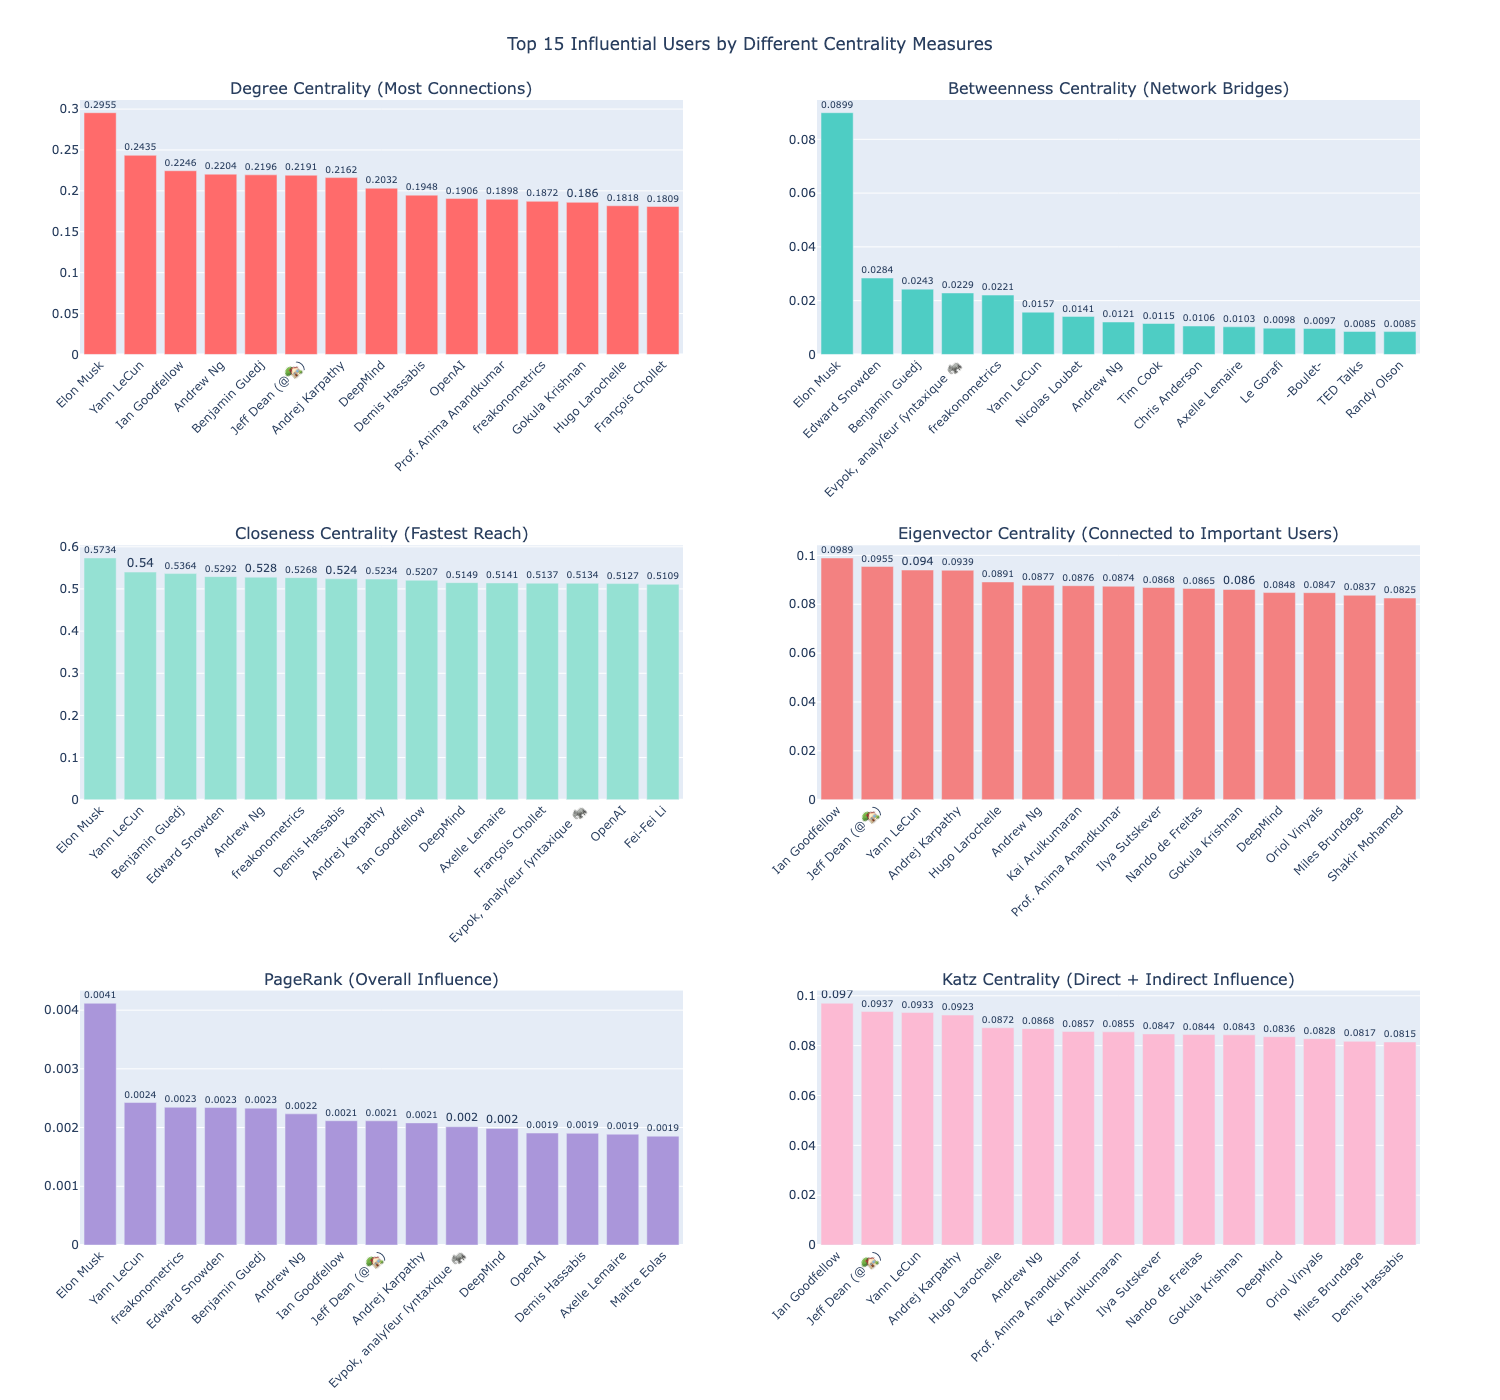

In [6]:
# Find top users by each centrality measure
top_n = 15

print("🌟 TOP INFLUENTIAL USERS BY CENTRALITY MEASURE")
print("=" * 80)

measures = {
    'degree': 'Degree Centrality (Most Connections)',
    'betweenness': 'Betweenness Centrality (Network Bridges)',
    'closeness': 'Closeness Centrality (Fastest Reach)',
    'eigenvector': 'Eigenvector Centrality (Connected to Important Users)',
    'pagerank': 'PageRank (Overall Influence)',
    'katz': 'Katz Centrality (Direct + Indirect Influence)',
}

top_users_by_measure = {}

for measure, description in measures.items():
    top_users = centrality_df.nlargest(top_n, measure)
    top_users_by_measure[measure] = top_users
    
    print(f"\n📊 {description}:")
    print("-" * 80)
    for idx, (i, row) in enumerate(top_users.iterrows(), 1):
        print(f"   {idx:2d}. {row['display_name']:20s} | Score: {row[measure]:.6f} | Connections: {row['degree_count']}")
    
    # Show overlap with other measures
    top_users_set = set(top_users['user'])
    overlaps = {}
    for other_measure, other_description in measures.items():
        if other_measure != measure:
            other_top = set(centrality_df.nlargest(top_n, other_measure)['user'])
            overlap = len(top_users_set & other_top)
            overlaps[other_measure] = overlap
    
    print(f"   Overlap with other top-{top_n} lists:")
    for other_measure, overlap in overlaps.items():
        print(f"      - {measures[other_measure]}: {overlap}/{top_n} users")

# Create visualization
fig = make_subplots(
    rows=3, cols=2,
    subplot_titles=list(measures.values()),
    specs=[[{"type": "bar"}, {"type": "bar"}],
           [{"type": "bar"}, {"type": "bar"}],
           [{"type": "bar"}, {"type": "bar"}]]
)

colors = ['#FF6B6B', '#4ECDC4', '#95E1D3', '#F38181', '#AA96DA', '#FCBAD3']
row_col = [(1,1), (1,2), (2,1), (2,2), (3,1), (3,2)]

for idx, (measure, description) in enumerate(measures.items()):
    top_users = top_users_by_measure[measure]
    row, col = row_col[idx]
    
    fig.add_trace(
        go.Bar(x=top_users['display_name'].map(lambda x: node_to_name.get(x, x)), y=top_users[measure],
               name=description, marker_color=colors[idx],
               text=top_users[measure].round(4),
               textposition='outside',
               hovertemplate='<b>%{x}</b><br>Score: %{y:.6f}<br>Connections: %{customdata}<extra></extra>',
               customdata=top_users['degree_count']),
        row=row, col=col
    )

# Update layout
for i in range(1, 4):
    for j in range(1, 3):
        fig.update_xaxes(tickangle=-45, row=i, col=j)

fig.update_layout(
    height=1400,
    showlegend=False,
    title_text="Top 15 Influential Users by Different Centrality Measures",
    title_x=0.5
)

fig.show()

### 2.2 Comparing Centrality Measures

Different centrality measures capture different aspects of influence. Let's compare them to understand:
- Which users are consistently influential across all measures?
- Which users are influential in specific ways?
- How do the measures correlate with each other?


🔗 CORRELATION BETWEEN CENTRALITY MEASURES

Correlation Matrix:
             degree  betweenness  closeness  eigenvector  pagerank   katz
degree        1.000        0.514      0.758        0.851     0.952  0.867
betweenness   0.514        1.000      0.386        0.234     0.633  0.251
closeness     0.758        0.386      1.000        0.547     0.778  0.566
eigenvector   0.851        0.234      0.547        1.000     0.660  0.999
pagerank      0.952        0.633      0.778        0.660     1.000  0.682
katz          0.867        0.251      0.566        0.999     0.682  1.000

🌟 USERS CONSISTENTLY INFLUENTIAL ACROSS MULTIPLE MEASURES

Users appearing in 3+ top-20 lists (22 users):

   Yann LeCun (ID: 48008938)
      Appears in 6/6 top-20 lists
      Degree: 580, Betweenness: 0.015721
      PageRank: 0.002426, Eigenvector: 0.093994

   Andrew Ng (ID: 216939636)
      Appears in 6/6 top-20 lists
      Degree: 525, Betweenness: 0.012061
      PageRank: 0.002233, Eigenvector: 0.087722

   De

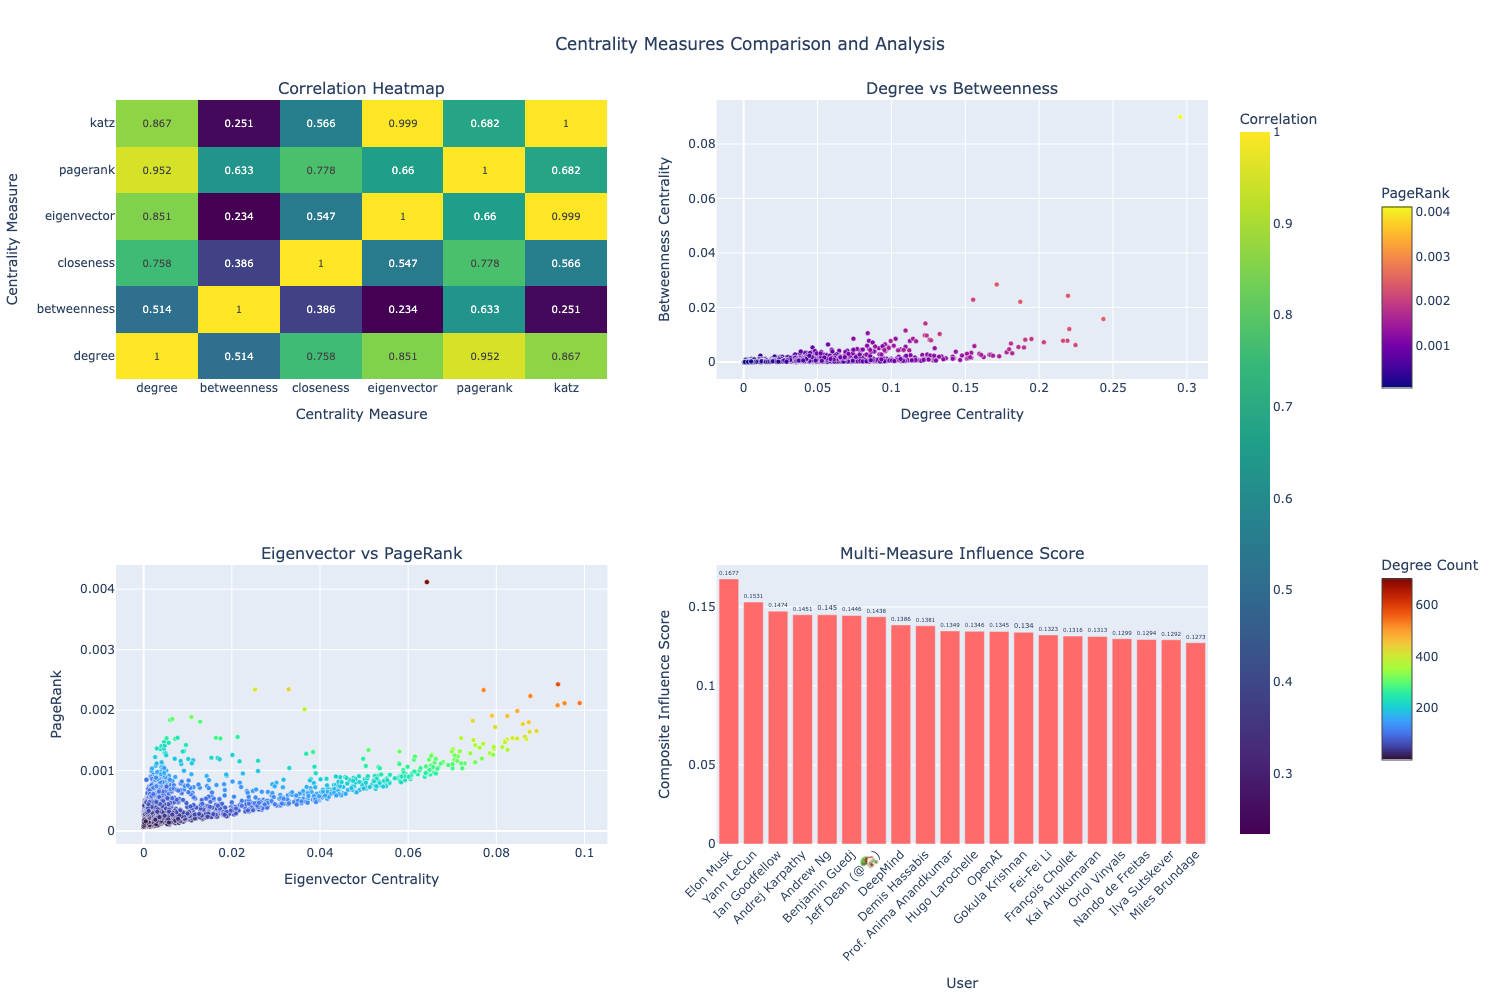

In [7]:
# Correlation analysis between centrality measures
print("🔗 CORRELATION BETWEEN CENTRALITY MEASURES")
print("=" * 60)

correlation_matrix = centrality_df[['degree', 'betweenness', 'closeness', 'eigenvector', 'pagerank', 'katz']].corr()

print("\nCorrelation Matrix:")
print(correlation_matrix.round(3))

# Find users who are consistently in top-N across multiple measures
print(f"\n🌟 USERS CONSISTENTLY INFLUENTIAL ACROSS MULTIPLE MEASURES")
print("=" * 60)

# Count how many top-20 lists each user appears in
user_scores = defaultdict(int)
for measure in ['degree', 'betweenness', 'closeness', 'eigenvector', 'pagerank', 'katz']:
    top_20 = set(centrality_df.nlargest(20, measure)['user'])
    for user in top_20:
        user_scores[user] += 1

# Users appearing in multiple top lists
multi_measure_users = {user: count for user, count in user_scores.items() if count >= 3}
sorted_multi = sorted(multi_measure_users.items(), key=lambda x: x[1], reverse=True)

print(f"\nUsers appearing in 3+ top-20 lists ({len(sorted_multi)} users):")
for user, count in sorted_multi[:20]:
    user_row = centrality_df[centrality_df['user'] == user].iloc[0]
    display_name = user_row['display_name']
    print(f"\n   {display_name} (ID: {user})")
    print(f"      Appears in {count}/6 top-20 lists")
    print(f"      Degree: {user_row['degree_count']}, Betweenness: {user_row['betweenness']:.6f}")
    print(f"      PageRank: {user_row['pagerank']:.6f}, Eigenvector: {user_row['eigenvector']:.6f}")

# Create comprehensive comparison visualization
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Correlation Heatmap', 'Degree vs Betweenness',
                   'Eigenvector vs PageRank', 'Multi-Measure Influence Score'),
    specs=[[{"type": "heatmap"}, {"type": "scatter"}],
           [{"type": "scatter"}, {"type": "bar"}]]
)

# Correlation heatmap
fig.add_trace(
    go.Heatmap(
        z=correlation_matrix.values,
        x=correlation_matrix.columns,
        y=correlation_matrix.columns,
        colorscale='Viridis',
        text=correlation_matrix.values.round(3),
        texttemplate='%{text}',
        textfont={"size": 10},
        colorbar=dict(title="Correlation", x=1.02)
    ),
    row=1, col=1
)

# Degree vs Betweenness scatter
fig.add_trace(
    go.Scatter(
        x=centrality_df['degree'],
        y=centrality_df['betweenness'],
        mode='markers',
        marker=dict(
            size=5,
            color=centrality_df['pagerank'],
            colorscale='Plasma',
            showscale=True,
            colorbar=dict(title="PageRank", x=1.15, y=0.75, len=0.3),
            line=dict(width=0.5, color='white')
        ),
        text=centrality_df['user'].map(lambda x: node_to_name.get(x, x)),
        hovertemplate='<b>%{text}</b><br>Degree: %{x:.4f}<br>Betweenness: %{y:.6f}<br>PageRank: %{marker.color:.6f}<extra></extra>',
        name='Users'
    ),
    row=1, col=2
)

# Eigenvector vs PageRank scatter
fig.add_trace(
    go.Scatter(
        x=centrality_df['eigenvector'],
        y=centrality_df['pagerank'],
        mode='markers',
        marker=dict(
            size=5,
            color=centrality_df['degree_count'],
            colorscale='Turbo',
            showscale=True,
            colorbar=dict(title="Degree Count", x=1.15, y=0.25, len=0.3),
            line=dict(width=0.5, color='white')
        ),
        text=centrality_df['user'].map(lambda x: node_to_name.get(x, x)),
        hovertemplate='<b>%{text}</b><br>Eigenvector: %{x:.6f}<br>PageRank: %{y:.6f}<br>Connections: %{marker.color}<extra></extra>',
        name='Users'
    ),
    row=2, col=1
)

# Multi-measure influence score
# Create a composite score
centrality_df['composite_score'] = (
    centrality_df['degree'] * 0.15 +
    centrality_df['betweenness'] * 0.15 +
    centrality_df['closeness'] * 0.15 +
    centrality_df['eigenvector'] * 0.15 +
    centrality_df['pagerank'] * 0.20 +
    centrality_df['katz'] * 0.20
)

top_composite = centrality_df.nlargest(20, 'composite_score')
fig.add_trace(
    go.Bar(x=top_composite['display_name'].map(lambda x: node_to_name.get(x, x)), y=top_composite['composite_score'],
           marker_color='#FF6B6B', text=top_composite['composite_score'].round(4),
           textposition='outside',
           hovertemplate='<b>%{x}</b><br>Composite Score: %{y:.6f}<extra></extra>'),
    row=2, col=2
)

# Update axes
fig.update_xaxes(title_text="Centrality Measure", row=1, col=1)
fig.update_yaxes(title_text="Centrality Measure", row=1, col=1)
fig.update_xaxes(title_text="Degree Centrality", row=1, col=2)
fig.update_yaxes(title_text="Betweenness Centrality", row=1, col=2)
fig.update_xaxes(title_text="Eigenvector Centrality", row=2, col=1)
fig.update_yaxes(title_text="PageRank", row=2, col=1)
fig.update_xaxes(title_text="User", tickangle=-45, row=2, col=2)
fig.update_yaxes(title_text="Composite Influence Score", row=2, col=2)

fig.update_layout(
    height=1000,
    width=1300,
    showlegend=False,
    title_text="Centrality Measures Comparison and Analysis",
    title_x=0.5
)

fig.show()

## Part III: Insights and Applications

Now let's extract meaningful insights from our centrality analysis and explore real-world applications.


### 3.1 Identifying Different Types of Influencers

In social networks, different users have different types of influence:

1. **Celebrities (High Degree)**: Users with many direct connections
2. **Bridge Users (High Betweenness)**: Users connecting different communities
3. **Opinion Leaders (High Eigenvector)**: Users connected to other influential users
4. **Information Spreaders (High Closeness)**: Users who can reach others quickly
5. **Overall Influencers (High PageRank)**: Users with balanced influence across measures

Centrality measures have many practical applications in social networks:

1. **Marketing & Advertising**: Target influential users for product promotion
2. **Information Spread**: Identify users who can spread information quickly
3. **Viral Content**: Find users likely to make content go viral
4. **Community Detection**: Use bridge users to understand community structure
5. **Influence Maximization**: Select seed users for maximum network coverage

In [10]:
# Application scenarios
print("💼 REAL-WORLD APPLICATIONS")
print("=" * 60)

# 1. Marketing: Best users to target for product promotion
print("\n1. 📢 MARKETING CAMPAIGN TARGETING")
print("-" * 60)
print("   Strategy: Target users with high PageRank (overall influence)")
print("   These users have balanced influence and can reach diverse audiences\n")
marketing_targets = centrality_df.nlargest(10, 'pagerank')
for idx, (i, row) in enumerate(marketing_targets.iterrows(), 1):
    print(f"   {idx:2d}. {row['display_name']:20s} | PageRank: {row['pagerank']:.6f} | Reach: {row['degree_count']} users")

# 2. Information Spread: Users who can spread news quickly
print("\n2. 📰 INFORMATION SPREAD (News/Viral Content)")
print("-" * 60)
print("   Strategy: Target users with high Closeness Centrality")
print("   These users can reach the entire network quickly\n")
info_spreaders = centrality_df.nlargest(10, 'closeness')
for idx, (i, row) in enumerate(info_spreaders.iterrows(), 1):
    print(f"   {idx:2d}. {row['display_name']:20s} | Closeness: {row['closeness']:.6f} | Avg Distance: {1/row['closeness']:.2f}")

# 3. Community Bridge: Users connecting different groups
print("\n3. 🌉 COMMUNITY BRIDGE USERS")
print("-" * 60)
print("   Strategy: Identify users with high Betweenness Centrality")
print("   These users connect different communities and can facilitate cross-group communication\n")
bridge_users = centrality_df.nlargest(10, 'betweenness')
for idx, (i, row) in enumerate(bridge_users.iterrows(), 1):
    print(f"   {idx:2d}. {row['display_name']:20s} | Betweenness: {row['betweenness']:.6f} | Connections: {row['degree_count']}")

# 4. Opinion Leaders: Users connected to other influencers
print("\n4. 👑 OPINION LEADERS")
print("-" * 60)
print("   Strategy: Target users with high Eigenvector Centrality")
print("   These users are connected to other influential users (prestige effect)\n")
opinion_leaders = centrality_df.nlargest(10, 'eigenvector')
for idx, (i, row) in enumerate(opinion_leaders.iterrows(), 1):
    print(f"   {idx:2d}. {row['display_name']:20s} | Eigenvector: {row['eigenvector']:.6f} | Connections: {row['degree_count']}")

# 5. Influence Maximization: Best seed set for maximum coverage
print("\n5. 🎯 INFLUENCE MAXIMIZATION (Seed Selection)")
print("-" * 60)
print("   Strategy: Select diverse set of high-influence users")
print("   Combining different centrality measures for maximum network coverage\n")
# Select top users from different measures (diverse seed set)
seed_set = set()
seed_set.update(centrality_df.nlargest(3, 'pagerank')['user'])
seed_set.update(centrality_df.nlargest(3, 'betweenness')['user'])
seed_set.update(centrality_df.nlargest(3, 'eigenvector')['user'])
seed_set.update(centrality_df.nlargest(3, 'closeness')['user'])

seed_df = centrality_df[centrality_df['user'].isin(seed_set)].copy()
seed_df = seed_df.sort_values('composite_score', ascending=False)

💼 REAL-WORLD APPLICATIONS

1. 📢 MARKETING CAMPAIGN TARGETING
------------------------------------------------------------
   Strategy: Target users with high PageRank (overall influence)
   These users have balanced influence and can reach diverse audiences

    1. Elon Musk            | PageRank: 0.004117 | Reach: 704 users
    2. Yann LeCun           | PageRank: 0.002426 | Reach: 580 users
    3. freakonometrics      | PageRank: 0.002346 | Reach: 446 users
    4. Edward Snowden       | PageRank: 0.002341 | Reach: 408 users
    5. Benjamin Guedj       | PageRank: 0.002331 | Reach: 523 users
    6. Andrew Ng            | PageRank: 0.002233 | Reach: 525 users
    7. Ian Goodfellow       | PageRank: 0.002116 | Reach: 535 users
    8. Jeff Dean (@🏡)       | PageRank: 0.002115 | Reach: 522 users
    9. Andrej Karpathy      | PageRank: 0.002079 | Reach: 515 users
   10. Evpok, analyſeur ſyntaxique 🐘 | PageRank: 0.002014 | Reach: 370 users

2. 📰 INFORMATION SPREAD (News/Viral Content)
------

### 3.2 Network Visualization with Centrality Highlighting

Let's visualize the network structure with nodes colored and sized by their centrality scores. This helps us see the network topology and identify influential users visually.


In [ ]:
import networkx as nx
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

print("📊 Creating network visualization...")

# Sample or subgraph if network is too large
if G.number_of_nodes() > 500:
    print(f"   Network has {G.number_of_nodes()} nodes. Creating visualization with top influential users and their neighborhoods...")
    top_users = set(centrality_df.nlargest(1, 'composite_score')['user'])
    neighborhood = set(top_users)
    for user in top_users:
        neighborhood.update(list(G.neighbors(user)))
    G_viz = G.subgraph(neighborhood).copy()
    print(f"   Visualization subgraph: {G_viz.number_of_nodes()} nodes, {G_viz.number_of_edges()} edges")
else:
    G_viz = G
    print(f"   Visualizing full network: {G_viz.number_of_nodes()} nodes")

print("   Computing network layout (this may take a moment)...")
pos = nx.spring_layout(G_viz, k=1, iterations=50, seed=42)

# Create subplots (3 rows x 2 columns) for 5 measures, leave last cell empty
fig = make_subplots(
    rows=3, cols=2,
    subplot_titles=('Network by Degree Centrality', 'Network by Betweenness Centrality',
                    'Network by PageRank', 'Network by Eigenvector Centrality',
                    'Network by Katz Centrality', ''),
    specs=[[{"type": "scatter"}, {"type": "scatter"}],
           [{"type": "scatter"}, {"type": "scatter"}],
           [{"type": "scatter"}, None]]
)

def create_network_plot(G_sub, pos_sub, centrality_dict, color_scale='Viridis'):
    """Create a network plot with nodes colored by centrality."""
    x_nodes = [pos_sub[node][0] for node in G_sub.nodes()]
    y_nodes = [pos_sub[node][1] for node in G_sub.nodes()]
    centrality_values = [centrality_dict.get(node, 0) for node in G_sub.nodes()]

    edge_x, edge_y = [], []
    for edge in G_sub.edges():
        x0, y0 = pos_sub[edge[0]]
        x1, y1 = pos_sub[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines',
        showlegend=False
    )

    node_trace = go.Scatter(
        x=x_nodes, y=y_nodes,
        mode='markers+text',
        marker=dict(
            size=[max(5, v * 500) if max(centrality_values) > 0 else 5 for v in centrality_values],
            color=centrality_values,
            colorscale=color_scale,
            showscale=True,
            colorbar=dict(title="Centrality", len=0.3),
            line=dict(width=0.5, color='white')
        ),
        text=[node if centrality_dict.get(node, 0) > np.percentile(centrality_values, 95) else '' 
              for node in G_sub.nodes()],
        textposition="middle center",
        textfont=dict(size=8),
        hovertext=[f"{node_to_name.get(node, node)}<br>Centrality: {centrality_dict.get(node, 0):.6f}" 
                   for node in G_sub.nodes()],
        hoverinfo='text',
        showlegend=False
    )

    return edge_trace, node_trace

# Centrality measures and colors
measures_viz = [
    ('degree', 'Blues'),
    ('betweenness', 'Reds'),
    ('pagerank', 'Greens'),
    ('eigenvector', 'Purples'),
    ('katz', 'Oranges')
]

# Add traces to subplots
for idx, (measure, color) in enumerate(measures_viz):
    row = (idx // 2) + 1
    col = (idx % 2) + 1
    centrality_dict = dict(zip(centrality_df['user'], centrality_df[measure]))
    edge_trace, node_trace = create_network_plot(G_viz, pos, centrality_dict, color)
    fig.add_trace(edge_trace, row=row, col=col)
    fig.add_trace(node_trace, row=row, col=col)

# Remove axes
for i in range(1, 4):
    for j in range(1, 3):
        fig.update_xaxes(showgrid=False, zeroline=False, showticklabels=False, row=i, col=j)
        fig.update_yaxes(showgrid=False, zeroline=False, showticklabels=False, row=i, col=j)

fig.update_layout(
    height=1400,
    showlegend=False,
    title_text="Network Visualization by Different Centrality Measures<br><sub>Node size and color represent centrality score</sub>",
    title_x=0.5
)

fig.show()

print("\n✅ Network visualization complete!")
print("   Larger, brighter nodes indicate higher centrality scores")
print("   Labels show only the top 5% most central nodes")

### Final summary and insights

In [20]:
print("📊 CENTRALITY ANALYSIS SUMMARY")
print("=" * 80)

print(f"\n📈 Network Overview:")
print(f"   Total Users: {G.number_of_nodes():,}")
print(f"   Total Connections: {G.number_of_edges():,}")
print(f"   Average Connections per User: {2*G.number_of_edges()/G.number_of_nodes():.2f}")
print(f"   Network Density: {nx.density(G):.6f}")

print(f"\n📊 Centrality Measure Insights:")
print(f"   - Degree Centrality Range: [{centrality_df['degree'].min():.6f}, {centrality_df['degree'].max():.6f}]")
print(f"   - Betweenness Centrality Range: [{centrality_df['betweenness'].min():.6f}, {centrality_df['betweenness'].max():.6f}]")
print(f"   - PageRank Range: [{centrality_df['pagerank'].min():.6f}, {centrality_df['pagerank'].max():.6f}]")
print(f"   - Katz Centrality Range: [{centrality_df['katz'].min():.6f}, {centrality_df['katz'].max():.6f}]")

# Key insights
print(f"\n💡 Key Insights:")
print(f"   1. Network Structure:")
print(f"      - {'Scale-free' if centrality_df['degree'].std() > centrality_df['degree'].mean() else 'More uniform'} degree distribution")
print(f"      - Average clustering: {nx.average_clustering(G):.4f} (higher = more tight-knit communities)")
print(f"      - Network diameter: {nx.diameter(G)} (maximum distance between any two users)")

print(f"\n   2. Influence Distribution:")
high_influence = len(centrality_df[centrality_df['composite_score'] > centrality_df['composite_score'].quantile(0.9)])
print(f"      - Top 10% influential users: {high_influence} users")
print(f"      - These users control {100*high_influence/G.number_of_nodes():.2f}% of network influence")

print(f"\n   3. Centrality Correlations:")
corr_pagerank_degree = centrality_df['pagerank'].corr(centrality_df['degree'])
corr_betweenness_eigen = centrality_df['betweenness'].corr(centrality_df['eigenvector'])
print(f"      - PageRank vs Degree: {corr_pagerank_degree:.3f} (high correlation = popular users are influential)")
print(f"      - Betweenness vs Eigenvector: {corr_betweenness_eigen:.3f} (low correlation = different influence types)")
corr_katz_pagerank = centrality_df['katz'].corr(centrality_df['pagerank'])
print(f"      - Katz vs PageRank: {corr_katz_pagerank:.3f} (similar algorithms, different implementations)")

print(f"\n   4. Practical Applications:")
print(f"      - Marketing: Target top {len(marketing_targets)} users by PageRank for maximum reach")
print(f"      - Information Spread: Use top {len(info_spreaders)} users by Closeness for fast dissemination")
print(f"      - Community Bridges: Leverage top {len(bridge_users)} users by Betweenness for cross-group communication")

# Create final summary dashboard
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Top 20 Influential Users', 'Centrality Score Distributions'),
    specs=[[{"type": "bar"}, {"type": "histogram"}]]
)

# Top 20 users
top_20 = centrality_df.nlargest(20, 'composite_score')
fig.add_trace(
    go.Bar(x=top_20['display_name'].map(lambda x: node_to_name.get(x, x)), y=top_20['composite_score'],
           marker_color='#FF6B6B', text=top_20['composite_score'].round(4),
           textposition='outside', name='Composite Score'),
    row=1, col=1
)

# Score distributions
fig.add_trace(
    go.Histogram(x=centrality_df['composite_score'], nbinsx=30,
                marker_color='#4ECDC4', name='Composite Score Distribution'),
    row=1, col=2
)

# Update axes
fig.update_xaxes(tickangle=-45, row=1, col=1)
fig.update_xaxes(title_text="Composite Influence Score", row=1, col=2)
fig.update_yaxes(title_text="Frequency", row=1, col=2)
fig.update_xaxes(title_text="Number of Direct Connections", row=2, col=2)
fig.update_yaxes(title_text="Number of Top 100 Users", row=2, col=2)

fig.update_layout(
    height=500,
    showlegend=False,
    title_text="Centrality Analysis Summary Dashboard",
    title_x=0.5
)

fig.show()

print("\n✅ Analysis complete! Review the visualizations above for detailed insights.")
print("\n🎓 Key Takeaways:")
print("   - Different centrality measures reveal different aspects of influence")
print("   - High-degree users (celebrities) are not always the most influential")
print("   - Bridge users (high betweenness) are crucial for information flow")
print("   - Combining multiple measures provides a more complete picture")
print("   - Understanding influence types helps in targeted marketing and communication strategies")

📊 CENTRALITY ANALYSIS SUMMARY

📈 Network Overview:
   Total Users: 2,383
   Total Connections: 88,135
   Average Connections per User: 73.97
   Network Density: 0.031054

📊 Centrality Measure Insights:
   - Degree Centrality Range: [0.000420, 0.295550]
   - Betweenness Centrality Range: [0.000000, 0.089886]
   - PageRank Range: [0.000069, 0.004117]
   - Katz Centrality Range: [0.001410, 0.097003]

💡 Key Insights:
   1. Network Structure:
      - Scale-free degree distribution
      - Average clustering: 0.3428 (higher = more tight-knit communities)
      - Network diameter: 6 (maximum distance between any two users)

   2. Influence Distribution:
      - Top 10% influential users: 239 users
      - These users control 10.03% of network influence

   3. Centrality Correlations:
      - PageRank vs Degree: 0.952 (high correlation = popular users are influential)
      - Betweenness vs Eigenvector: 0.234 (low correlation = different influence types)
      - Katz vs PageRank: 0.682 (simila


✅ Analysis complete! Review the visualizations above for detailed insights.

🎓 Key Takeaways:
   - Different centrality measures reveal different aspects of influence
   - High-degree users (celebrities) are not always the most influential
   - Bridge users (high betweenness) are crucial for information flow
   - Combining multiple measures provides a more complete picture
   - Understanding influence types helps in targeted marketing and communication strategies
